Julio B. Roll - PS2

Distribution fitting (generalized beta) on healthcare claims data.

First, let's import some packages, a distribs.py with our distributions and our data:

In [2]:
# importing claims
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy.special as spc
import scipy.integrate as intgr
import distribs

clms = np.loadtxt('clms.txt')

### Question a)

Mean:  720.277975327
Median:  172.21
Max:  227967.25
Min:  0.01
Std:  3972.66375639


<IPython.core.display.Javascript object>


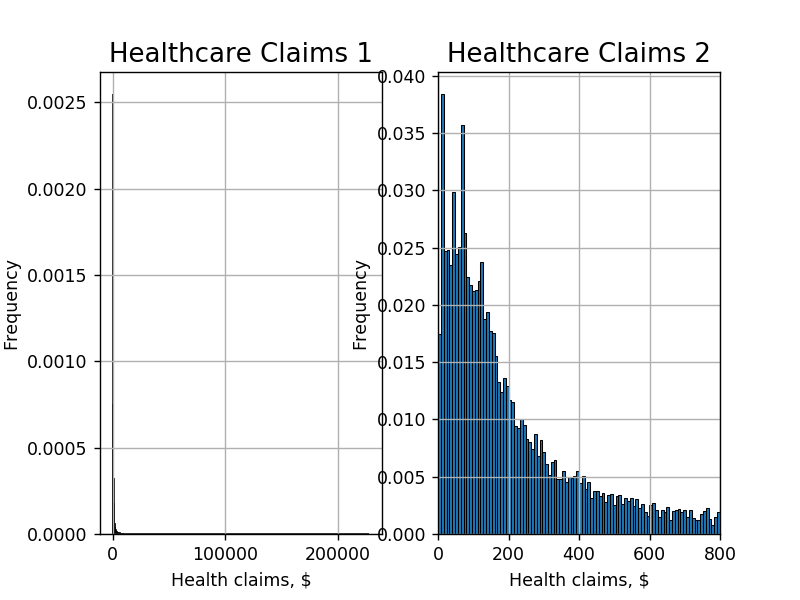

0.8494208494208465

In [3]:
# Basic description
print('Mean: ', np.mean(clms))
print('Median: ', np.median(clms))
print('Max: ', np.max(clms))
print('Min: ', np.min(clms))
print('Std: ', np.std(clms))

# First histogram
%matplotlib notebook
plt.figure(0)
plt.subplot(1, 2, 1)
count, bins, ignored = plt.hist(clms, 1000, edgecolor='black', normed=True)
plt.title('Healthcare Claims 1', fontsize=15)
plt.xlabel('Health claims, $')
plt.ylabel('Frequency')
plt.grid()

# Second histogram, adjusting heights, with less bins
adjust2 = np.transpose(np.ones(np.size(clms[(clms <= 800)]))/np.size(clms))
plt.subplot(1, 2, 2)
count, bins, ignored = plt.hist(clms[(clms <= 800)], 100, edgecolor='black', linewidth=0.6, 
                                normed=False, weights=adjust2)
plt.title('Healthcare Claims 2', fontsize=15)
plt.xlabel('Health claims, $')
plt.ylabel('Frequency')
plt.grid()
plt.xlim([0, 800])

# to verify the sum of the frequencies:

count.sum()

<div style="text-align: justify"> The second one is preferred because the distribution mass is, clearly, concentrated on smaller values. As such, even if we take 1000 bins, we don't get a "mesh" that is fine enough where it needs to so as to represent well the distribution at the smaller values, i.e. we get two "super" tall columns that represent, conjointly, around 75% of the distribution. As such, the histogram does not tell much, since it lacks sensitivity in that region (which we get with the second plot). </div> <br>

<div style="text-align: justify"> One should also notice that eliminating clms > 800 is conditioned on the questions that the model is supposed to answer. If one is interested in the general distribution, then those points do, indeed, carry little information (as shown by the LHS plot). However, one might be interested in the high-end of the distribution, meaning cutting it off wouldn't be advisable. </div>


### Question b)

For reference:

$$ \text{(GA):}\quad f(x;\alpha,\beta) = \frac{1}{\beta^\alpha \Gamma(\alpha)}x^{\alpha-1}e^{-\frac{x}{\beta}},\quad x\in[0,\infty), \:\alpha,\beta>0 $$ <br>
$$ \text{where}\quad \Gamma(z)\equiv\int_0^\infty t^{z-1}e^{-t}dt $$ <br>
$$ \beta_0 = \frac{E(x)}{Var(x)} $$ <br>
$$ \alpha_0 = \frac{E(x)}{\beta_0} $$<br>
Let's define some auxiliary functions:

In [4]:
# Define log likelihood function for the gamma distribution
def log_lik_gamma(xvals, alpha, beta):
    '''
    --------------------------------------------------------------------
    Compute the log likelihood function for data xvals given gamma
    distribution parameters alpha and beta
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, values of the gamma distributed random
             variable
    alpha  = scalar > 0, shape
    beta   = scalar > 0, rate
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        distribs.gamma_pdf()
    
    OBJECTS CREATED WITHIN FUNCTION:
    pdf_vals    = (N,) vector, gamma PDF values for alpha and beta
                  corresponding to xvals data
    ln_pdf_vals = (N,) vector, natural logarithm of gamma PDF values
                  for alpha and beta corresponding to xvals data
    log_lik_val = scalar, value of the log likelihood function
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: log_lik_val
    --------------------------------------------------------------------
    '''
    pdf_vals = distribs.gamma_pdf(xvals, alpha, beta)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

In [5]:
def crit_gamma(params, xvals):
    '''
    --------------------------------------------------------------------
    This function computes the negative of the log likelihood function
    given parameters and data. This is the minimization problem version
    of the maximum likelihood optimization problem
    --------------------------------------------------------------------
    INPUTS:
    params = (2,) vector, ([alpha, beta])
    alpha  = scalar > 0, shape
    beta   = scalar > 0, rate
    xvals  = (N,) vector, values of the gamma distributed random
             variable
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        log_lik_gamma()
    
    OBJECTS CREATED WITHIN FUNCTION:
    log_lik_val = scalar, value of the log likelihood function
    neg_log_lik_val = scalar, negative of log_lik_val
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: neg_log_lik_val
    --------------------------------------------------------------------
    '''
    alpha, beta = params
    log_lik_val = log_lik_gamma(xvals, alpha, beta)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

Optimization routine: L-BFGS-B is pretty sensitive to the initial parameters, which required a reduction of the initial $\beta_0$. On the other hand, Nelder-Mead, not requiring a gradient, is more robust to noise (at some performance cost, which is not an issue here).

An extremely big $\beta_0$ can produce two types of problems:

i) it could "numb" the optimizer, meaning the routine is running at a region where the variations in the function aren't significant (think of an atom's potential well);

ii) the optimization step (e.g. based on the gradient) might have a problem changing the value of $\beta_0$ (it's not "strong enough").

For these reasons, I've reduced its value. For robustness, one can run using Nelder-Mead, which gives the same results (even for the original initial parameters, though with a couple of warnings).

In [6]:
beta_0 = np.var(clms)/np.mean(clms)
alpha_0 = np.mean(clms)/beta_0
print('alpha_0 = ', alpha_0, 'beta_0 = ', beta_0 - 21000)
params_init = np.array([alpha_0, beta_0 - 21000])
mle_args = (clms)
results1 = opt.minimize(crit_gamma, params_init, args = (mle_args),method= 'L-BFGS-B')
# results1 = opt.minimize(crit_gamma, params_init, args = (mle_args),method= 'Nelder-Mead')
alpha_MLE_gamma, beta_MLE_gamma = results1.x
print('alpha_MLE_gamma =', alpha_MLE_gamma, 'beta_MLE_gamma =', beta_MLE_gamma)

alpha_0 =  0.0328727966942 beta_0 =  911.064702754
alpha_MLE_gamma = 0.472519290299 beta_MLE_gamma = 1524.30386247


In [7]:
print(results1)
print('Max Log-Likelihood = ', -results1.fun)

      fun: 77723.47342674734
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.,  0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 96
      nit: 29
   status: 0
  success: True
        x: array([  4.72519290e-01,   1.52430386e+03])
Max Log-Likelihood =  -77723.4734267


Plotting: I'm renormalizing the histogram of values $\leq $800$ since it allows for a comparison with the estimated gamma distribution.

<IPython.core.display.Javascript object>


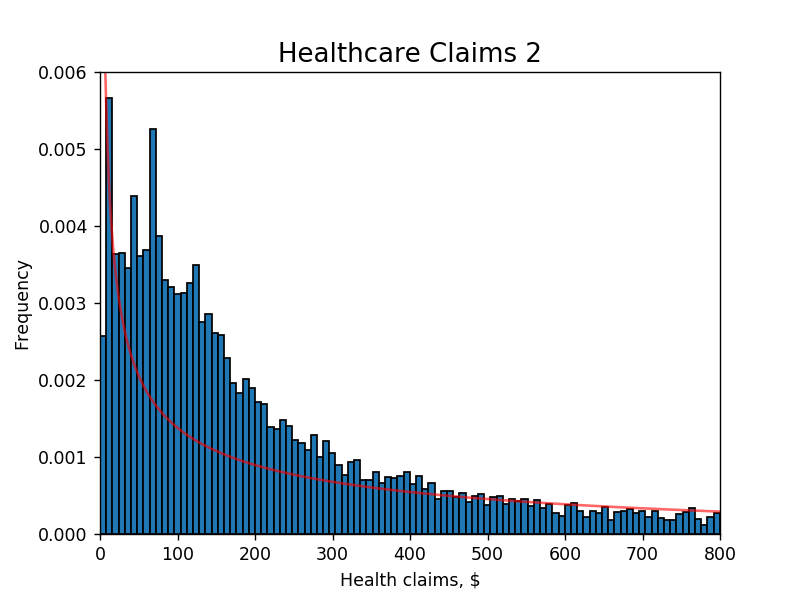

(0, 0.006)

In [8]:
dist_pts = np.linspace(0.0000001, 800, 1600)
pdf_vals = distribs.gamma_pdf(dist_pts, alpha_MLE_gamma, beta_MLE_gamma)
plt.figure(1)
plt.plot(dist_pts,pdf_vals,'r-', alpha=0.6, label='gamma pdf')
plt.xlim([0, 800])

# Second histogram, adjusting heights
adjust2 = np.transpose(np.ones(np.size(clms[(clms <= 800)]))/np.size(clms))
count, bins, ignored = plt.hist(clms[(clms <= 800)], 100, edgecolor='black', normed=True,
                                weights=adjust2)
plt.title('Healthcare Claims 2', fontsize=15)
plt.xlabel('Health claims, $')
plt.ylabel('Frequency')
plt.xlim([0, 800])
plt.ylim([0, 0.006])

We seem to be missing the data peak after zero. It might be an issue with the tail of the data: our representation might not be enough to represent both the long tail and the peak behavior. Also, our curve goes down too quickly, under-representing the mid-range values.

Before changing the distribution, we could estimate a Gamma curve only with the $\leq $800$ data (to get an intuition):

In [9]:
beta_0 = np.var(clms)/np.mean(clms)
alpha_0 = np.mean(clms)/beta_0
print('alpha_0 = ', alpha_0, 'beta_0 = ', beta_0 - 21000)
params_init = np.array([alpha_0, beta_0 - 21000])
mle_args = (clms[clms <= 800])
results2 = opt.minimize(crit_gamma, params_init, args = (mle_args),method= 'L-BFGS-B')
# results2 = opt.minimize(crit_gamma, params_init, args = (mle_args),method= 'Nelder-Mead')
alpha_MLE_gamma_800, beta_MLE_gamma_800 = results2.x
print('alpha_MLE_gamma_800 =', alpha_MLE_gamma_800, 'beta_MLE_gamma_800 =', beta_MLE_gamma_800)

alpha_0 =  0.0328727966942 beta_0 =  911.064702754
alpha_MLE_gamma_800 = 1.13973239716 beta_MLE_gamma_800 = 174.873045724


In [10]:
params_init = np.array([alpha_MLE_gamma_800, beta_MLE_gamma_800])
mle_args = (clms)
results10 = opt.minimize(crit_gamma, params_init, args = (mle_args),method= 'L-BFGS-B')
# results10 = opt.minimize(crit_gamma, params_init, args = (mle_args),method= 'Nelder-Mead')
alpha_MLE_test, beta_MLE_test = results10.x
print('alpha_MLE_test =', alpha_MLE_test, 'beta_MLE_test =', beta_MLE_test)

alpha_MLE_test = 1.13973239716 beta_MLE_test = 174.873045724


C:\Users\Public\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log
C:\Users\Public\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


In [56]:
print(results2)
print('Max Log-Likelihood = ', -results2.fun)

      fun: 56732.598680628784
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.08149073, -0.0007276 ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 111
      nit: 31
   status: 0
  success: True
        x: array([   1.1397324 ,  174.87304572])
Max Log-Likelihood =  56732.5986806


<IPython.core.display.Javascript object>


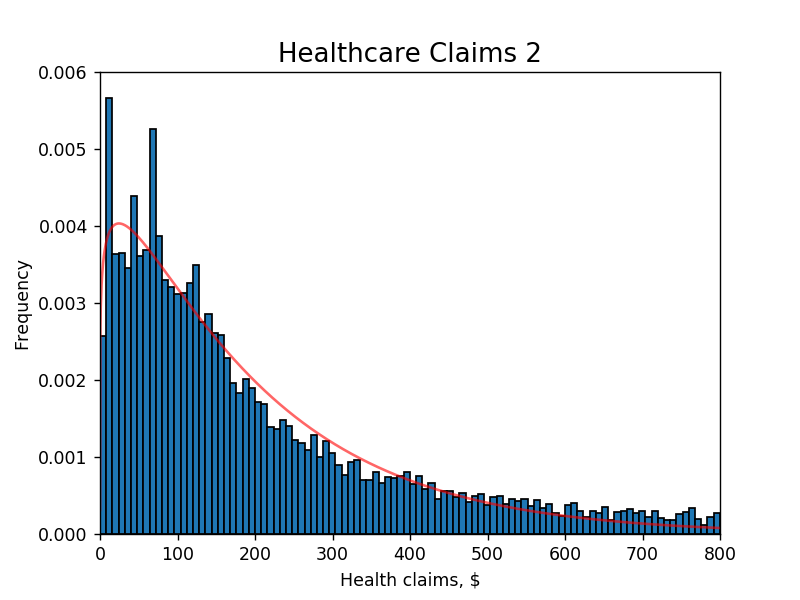

(0, 0.006)

In [35]:
dist_pts = np.linspace(0.0000001, 800, 1600)
pdf_vals = distribs.gamma_pdf(dist_pts, alpha_MLE_gamma_800, beta_MLE_gamma_800)
plt.figure(2)
plt.plot(dist_pts,pdf_vals,'r-', alpha=0.6, label='gamma pdf')
plt.xlim([0, 800])

# Second histogram, adjusting heights
adjust2 = np.transpose(np.ones(np.size(clms[(clms <= 800)]))/np.size(clms))
count, bins, ignored = plt.hist(clms[(clms <= 800)], 100, edgecolor='black', normed=True,
                                weights=adjust2)
plt.title('Healthcare Claims 2', fontsize=15)
plt.xlabel('Health claims, $')
plt.ylabel('Frequency')
plt.xlim([0, 800])
plt.ylim([0, 0.006])

We do get a peak, but the tail is, obviously, too low to represent the entire sample.

### Question c)

For reference:

$$ \text{(GG):}\quad f(x;\alpha,\beta,m) = \frac{m}{\beta^\alpha \Gamma(\frac{\alpha}{m})}x^{\alpha-1}e^{-(\frac{x}{\beta})^m},\quad x\in[0,\infty), \:\alpha,\beta,m>0 $$ <br>
$$ \text{where}\quad \Gamma(z)\equiv\int_0^\infty t^{z-1}e^{-t}dt $$ <br>
Again, let's define some auxiliary functions:

In [37]:
# Define log likelihood function for the generalied gamma distribution
def log_lik_gengamma(xvals, alpha, beta, m):
    '''
    --------------------------------------------------------------------
    Compute the log likelihood function for data xvals given generalied
    gamma distribution parameters alpha, beta and m
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, values of the generalizedd gamma distributed random
             variable
    alpha  = scalar > 0, shape
    beta   = scalar > 0, rate
    m      = scalar > 0, parameter
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        distribs.gengamma_pdf()
    
    OBJECTS CREATED WITHIN FUNCTION:
    pdf_vals    = (N,) vector, generalied gamma PDF values for alpha, beta
                   and m corresponding to xvals data
    ln_pdf_vals = (N,) vector, natural logarithm of generalied gamma PDF values
                  for alpha, beta and m corresponding to xvals data
    log_lik_val = scalar, value of the log likelihood function
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: log_lik_val
    --------------------------------------------------------------------
    '''
    pdf_vals = distribs.gengamma_pdf(xvals, alpha, beta, m)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

In [38]:
def crit_gengamma(params, xvals):
    '''
    --------------------------------------------------------------------
    This function computes the negative of the log likelihood function
    given parameters and data. This is the minimization problem version
    of the maximum likelihood optimization problem
    --------------------------------------------------------------------
    INPUTS:
    params = (3,) vector, ([alpha, beta, m])
    alpha  = scalar > 0, shape
    beta   = scalar > 0, rate
    m      = scalar > 0, parameter
    xvals  = (N,) vector, values of the generalized gamma distributed random
             variable
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        log_lik_gengamma()
    
    OBJECTS CREATED WITHIN FUNCTION:
    log_lik_val = scalar, value of the log likelihood function
    neg_log_lik_val = scalar, negative of log_lik_val
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: neg_log_lik_val
    --------------------------------------------------------------------
    '''
    alpha, beta, m = params
    log_lik_val = log_lik_gengamma(xvals, alpha, beta, m)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

Optimization routine: like previoiusly, for the L-BFGS-B one is required to reduce the initial $\beta_0$. One should note that Nelder-Mead converges (more slowly, due to its performance) to a different solution. However, the latter sends beta to a low value, which begs the question if the solver isn't hitting a corner (which is why I'm using L-BFGS-B here).

In [107]:
m_0 = 1
print('alpha_0 = ', alpha_MLE_gamma, 'beta_0 = ', beta_MLE_gamma - 600, 'm_0 = ', m_0)
params_init = np.array([alpha_MLE_gamma, beta_MLE_gamma - 600, m_0])
mle_args = (clms)
results3= opt.minimize(crit_gengamma, params_init, args = (mle_args),method= 'L-BFGS-B')
#results3 = opt.minimize(crit_gengamma, params_init, args = (mle_args),method= 'Nelder-Mead')
alpha_MLE_gengamma, beta_MLE_gengamma, m_MLE_gengamma = results3.x
print('alpha_MLE_gengamma =', alpha_MLE_gengamma, 'beta_MLE_gengamma =', beta_MLE_gengamma,
     'm_MLE_gengamma = ', m_MLE_gengamma)

alpha_0 =  0.472519290299 beta_0 =  924.303862475 m_0 =  1
alpha_MLE_gengamma = 0.520584609326 beta_MLE_gengamma = 924.303730011 m_MLE_gengamma =  0.719611559783


In [108]:
print(results3)
print('Max Log-Likelihood = ', -results3.fun)

      fun: 76772.277764874583
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.66356733,  0.95024006, -1.01717887])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 36
      nit: 6
   status: 0
  success: True
        x: array([  5.20584609e-01,   9.24303730e+02,   7.19611560e-01])
Max Log-Likelihood =  -76772.2777649


In [100]:
dist_pts = np.linspace(0.0000001, 800, 1600)
pdf_vals = distribs.gengamma_pdf(dist_pts, alpha_MLE_gengamma, beta_MLE_gengamma, m_MLE_gengamma)
plt.figure(1)
plt.plot(dist_pts,pdf_vals,'g-', alpha=0.6, label='gengamma pdf')
plt.xlim([0, 800])

(0, 800)

Results are similar to the ones obtained with the Gamma distribution.

### Question d)

For reference:

$$ \text{(GB2):}\quad f(x;a,b,p,q) = \frac{ax^{ap-1}}{b^{ap} B(p,q)\big(1 + (\frac{x}{b})^a\big)^{p+q}},\quad x\in[0,\infty), \:a,b,p,q>0 $$ <br>
$$ \text{where}\quad B(v,w)\equiv\int_0^1 t^{v-1}(1 - t)^{w-q}dt $$ <br>
Again, let's define some auxiliary functions:

In [70]:
# Define log likelihood function for the generalied gamma distribution
def log_lik_genbeta2(xvals, a, b, p, q):
    '''
    --------------------------------------------------------------------
    Compute the log likelihood function for data xvals given generalied
    beta 2 distribution parameters a, b, p, q
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, values of the generalizedd beta 2 distributed random
             variable
    a      = scalar > 0, parameter
    b      = scalar > 0, parameter
    p      = scalar > 0, parameter
    q      = scalar > 0, parameter
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        distribs.genbeta2_pdf()
    
    OBJECTS CREATED WITHIN FUNCTION:
    pdf_vals    = (N,) vector, generalied beta 2 PDF values for a, b, p, q
                  corresponding to xvals data
    ln_pdf_vals = (N,) vector, natural logarithm of generalied gamma PDF values
                  for a, b, p, q corresponding to xvals data
    log_lik_val = scalar, value of the log likelihood function
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: log_lik_val
    --------------------------------------------------------------------
    '''
    pdf_vals = distribs.genbeta2_pdf(xvals, a, b, p, q)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

In [71]:
def crit_genbeta2(params, xvals):
    '''
    --------------------------------------------------------------------
    This function computes the negative of the log likelihood function
    given parameters and data. This is the minimization problem version
    of the maximum likelihood optimization problem
    --------------------------------------------------------------------
    INPUTS:
    params = (4,) vector, ([a, b, p, q])
    a      = scalar > 0, parameter
    b      = scalar > 0, parameter
    p      = scalar > 0, parameter
    q      = scalar > 0, parameter
    xvals  = (N,) vector, values of the generalized beta 2 distributed random
             variable
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        log_lik_genbeta2()
    
    OBJECTS CREATED WITHIN FUNCTION:
    log_lik_val = scalar, value of the log likelihood function
    neg_log_lik_val = scalar, negative of log_lik_val
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: neg_log_lik_val
    --------------------------------------------------------------------
    '''
    a, b, p, q = params
    log_lik_val = log_lik_genbeta2(xvals, a, b, p, q)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

Optimization routine: L-BFGS-B couldn't converge, so I've switched to the more noise-robust method (I had to set $q_0$ higher). We can observe some performance slowdown (it takes a few seconds).

In [109]:
q_0 = 100000
a_0 = m_MLE_gengamma
b_0 = beta_MLE_gengamma * q_0 ** (1/m_MLE_gengamma)
p_0 = alpha_MLE_gengamma/m_MLE_gengamma

print('a_0 = ', a_0, 'b_0 = ', b_0, 'p_0 = ', p_0, 'q_0 = ', q_0)
params_init = np.array([a_0, b_0, p_0, q_0])
mle_args = (clms)
#results4= opt.minimize(crit_genbeta2, params_init, args = (mle_args),method= 'L-BFGS-B')
results4 = opt.minimize(crit_genbeta2, params_init, args = (mle_args), options={'maxiter':1000}, 
                        method= 'Nelder-Mead')
a_MLE_genbeta2, b_MLE_genbeta2, p_MLE_genbeta2, q_MLE_genbeta2 = results4.x
print('a_MLE_genbeta2 =', a_MLE_genbeta2, 'b_MLE_genbeta2 =', b_MLE_genbeta2,
     'p_MLE_genbeta2 = ', p_MLE_genbeta2, 'q_MLE_genbeta2 = ', q_MLE_genbeta2)

a_0 =  0.719611559783 b_0 =  8203660935.38 p_0 =  0.723424467338 q_0 =  100000
a_MLE_genbeta2 = 0.557093570106 b_MLE_genbeta2 = 89.5860214293 p_MLE_genbeta2 =  4.10051489632 q_MLE_genbeta2 =  2.88906034584


In [110]:
print(results4)
print('Max Log-Likelihood = ', -results4.fun)

 final_simplex: (array([[  0.55709357,  89.58602143,   4.1005149 ,   2.88906035],
       [  0.55709364,  89.58592443,   4.10051578,   2.88905926],
       [  0.55709361,  89.58594937,   4.10051547,   2.88905937],
       [  0.55709357,  89.58601585,   4.10051492,   2.88906024],
       [  0.55709361,  89.58593097,   4.10051546,   2.88905925]]), array([ 74755.33223236,  74755.33223236,  74755.33223236,  74755.33223236,
        74755.33223236]))
           fun: 74755.332232361601
       message: 'Optimization terminated successfully.'
          nfev: 1568
           nit: 925
        status: 0
       success: True
             x: array([  0.55709357,  89.58602143,   4.1005149 ,   2.88906035])
Max Log-Likelihood =  -74755.3322324


In [101]:
dist_pts = np.linspace(0.0000001, 800, 1600)
pdf_vals = distribs.genbeta2_pdf(dist_pts, a_MLE_genbeta2, b_MLE_genbeta2, p_MLE_genbeta2,
                                 q_MLE_genbeta2)
plt.figure(1)
plt.plot(dist_pts,pdf_vals,'m-', alpha=0.6, label='genbeta2 pdf')
plt.xlim([0, 800])

(0, 800)

And we get a peak! Also, the mid-range values seem better represented.

One should also note the evolution of the max log-likelihood: as expected, the unconstrained distribution is showing better results.

### Question e

We want to perform a likelihood ratio test. Our test statistic is:
$$ LR(\tilde\theta|\hat\theta_{MLE}) = 2\big(ln \mathrm{l} (\hat\theta_{MLE}) - \mathrm{l} (\tilde\theta)\big) \sim \chi^2(p) $$ <br>

In [115]:
loglik_gamma = log_lik_gamma(clms, alpha_MLE_gamma, beta_MLE_gamma)
loglik_gengamma = log_lik_gengamma(clms, alpha_MLE_gengamma, beta_MLE_gengamma, m_MLE_gengamma)
loglik_genbeta2 = log_lik_genbeta2(clms, a_MLE_genbeta2, b_MLE_genbeta2, p_MLE_genbeta2,
                               q_MLE_genbeta2)
LR_val_gamma = 2 * (loglik_genbeta2 - loglik_gamma)
LR_val_gengamma = 2 * (loglik_genbeta2 - loglik_gengamma)

print('LR GB2 vs. Gamma = ', LR_val_gamma)
print('LR GB2 vs. Generalized Gamma = ', LR_val_gengamma)

pval_gamma = 1.0 - sts.chi2.cdf(LR_val_gamma, 4)
pval_gengamma = 1.0 - sts.chi2.cdf(LR_val_gengamma, 4)

print('p-value for the gamma distribution = ', pval_gamma)
print('p-value for the generalized gamma distribution = ', pval_gengamma)

LR GB2 vs. Gamma =  5936.28238877
LR GB2 vs. Generalized Gamma =  4033.89106503
p-value for the gamma distribution =  0.0
p-value for the generalized gamma distribution =  0.0


In both cases, we accept our H1 (the generalized beta 2).

### Question f)

Finally, we want to use our GB2 distribution to estimate the probability of having a monthly health care claim $> $1000$. And then, compare with the value obtained using the GA distribution.

In [126]:
# Some integration
xfx_gb2 = lambda x: distribs.genbeta2_pdf(x, a_MLE_genbeta2, b_MLE_genbeta2, 
                                             p_MLE_genbeta2, q_MLE_genbeta2)
(prob_gb2_compl, prob_gb2_err) = intgr.quad(xfx_gb2, 0, 1000)
prob_gb2 = 1 - prob_gb2_compl

xfx_gamma = lambda x: distribs.gamma_pdf(x, alpha_MLE_gamma, beta_MLE_gamma) 
(prob_gamma_compl, prob_gamma_err) = intgr.quad(xfx_gamma, 0, 1000)
prob_gamma = 1 - prob_gamma_compl

print('GB2: Probability health claim > $1000 = ', prob_gb2)
print('Gamma: Probability health claim > $1000 = ', prob_gamma)

GB2: Probability health claim > $1000 =  0.125438177069213
Gamma: Probability health claim > $1000 =  0.236773147543209


To try to understand what those values mean, let's calculate the $> $1000$ ratio straight from our sample:

In [127]:
print("> $1000 sample ratio = ",np.size(clms[clms>1000])/np.size(clms))

> $1000 sample ratio =  0.12261041529334213


As expected from what we can see in the histrogram, the Gamma distribution has a fatter tail and, as such, overestimates high health claim values. The Generalized Beta 2 distribution does a better job at representing the sample.